In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
df = pd.read_csv("genes/combined-gene-on-off.csv")
df = df[df.celltype=="HBEC"]
df.head(1)

,gene,off-period,on-period,off-mean,on-mean,K-off-rate,K-on-rate,off-median,on-median,off-period-counts,on-period-counts,TATA_group,inr_group,chr_x,strand_x,TSS,geneID,TATA +,YY1 +,SP +,SP -,ETS +,ETS -,NFY +,NFY -,CREB +,CREB -,NRF1 +,NRF1 -,ZNF143 +,ZNF143 -,U1 snRNP +,chr_y,start,end,strand_y,gene_id,transcript_id,distance2tss,Sum of initiator effect,celltype,strand,H3K27me3_tss,cluster,gene_type,comment
0,LUZP1,"[213, 55, 11, 40]","[7, 7, 2]",79.75,5.333333,0.1875,0.012539,47.5,7.0,4,3,without_TATA,without_inr,chr1,-,23178121.0,ENSG00000169641.9,0.009,0.011,-0.126,-0.16,-0.028,-0.07,0.045,0.065,0.498,0.435,-0.004,0.001,-0.001,-0.067,0.186,chr1,23084023.0,23177808.0,-,ENSG00000169641,NaN,313.0,1.355976,HBEC,-,0.0,cluster0,simple,NaN


In [30]:
df.columns

Index(['gene', 'off-period', 'on-period', 'off-mean', 'on-mean', 'K-off-rate',
       'K-on-rate', 'off-median', 'on-median', 'off-period-counts',
       'on-period-counts', 'TATA_group', 'inr_group', 'chr_x', 'strand_x',
       'TSS', 'geneID', 'TATA +', 'YY1 +', 'SP +', 'SP -', 'ETS +', 'ETS -',
       'NFY +', 'NFY -', 'CREB +', 'CREB -', 'NRF1 +', 'NRF1 -', 'ZNF143 +',
       'ZNF143 -', 'U1 snRNP +', 'chr_y', 'start', 'end', 'strand_y',
       'gene_id', 'transcript_id', 'distance2tss', 'Sum of initiator effect',
       'celltype', 'strand', 'H3K27me3_tss', 'cluster', 'gene_type',
       'comment'],
      dtype='object')

In [31]:
# get a per gene peak counts and coverage 
# Define your files along with the corresponding score type (genebody or tss)
files = [
    "HBEC_ATAC_sorted_peaks.narrowPeak",
    "HBEC_H3K27ac_peaks.narrowPeak",
    "HBEC_H3K36me3_peaks.narrowPeak",
    "HBEC_H3K4me1_peaks.narrowPeak",
    "HBEC_H3K4me3_peaks.narrowPeak",
]



# Assuming df_wan is your initial DataFrame
for file in files:
   
    histone = file.split('_')[1]
    
    peak_counts = []
    peak_coverage = []
    df_temp = pd.read_csv(f"/storage/zhangyanxiaoLab/qihongjian/projects/transcriptome_4D/data/bam/HBEC/{file}", header=None, sep='\t',
                          names=["chrom", "start", "end", "name", "score", "strand",
                                 "fc", "pvalue", "qvalue", "summit_pos"])
    df_temp["size"] = df_temp["end"] - df_temp["start"]
    
    

    for index, row in df.iterrows():
        chrom, tss = row['chr_x'], row['TSS']
        
        # Define the region around TSS
        start_region = tss - 100_000  # 50k upstream
        end_region = tss + 100_000    # 50k downstream
        
        # Filter peaks within this region
        peaks_in_region = df_temp[(df_temp['chrom'] >= chrom) & (df_temp['end'] >= start_region) & (df_temp['start'] <= end_region)]
        
        # Initialize variable for total coverage
        total_coverage = 0
        # Calculate coverage for each peak
        for _, peak in peaks_in_region.iterrows():
            # Calculate the overlap between the peak and the TSS region
            overlap_start = max(start_region, peak['start'])
            overlap_end = min(end_region, peak['end'])
            overlap = overlap_end - overlap_start
            
            # Sum the overlaps for total coverage
            total_coverage += overlap
        
        # Append the results
        peak_counts.append(len(peaks_in_region))
        peak_coverage.append(total_coverage)
    
    # Add results to df_wan
    df[f'{histone}_peak_counts'] = peak_counts
    df[f'{histone}_peak_coverage'] = peak_coverage
    
  
    


In [32]:
df.columns

Index(['gene', 'off-period', 'on-period', 'off-mean', 'on-mean', 'K-off-rate',
       'K-on-rate', 'off-median', 'on-median', 'off-period-counts',
       'on-period-counts', 'TATA_group', 'inr_group', 'chr_x', 'strand_x',
       'TSS', 'geneID', 'TATA +', 'YY1 +', 'SP +', 'SP -', 'ETS +', 'ETS -',
       'NFY +', 'NFY -', 'CREB +', 'CREB -', 'NRF1 +', 'NRF1 -', 'ZNF143 +',
       'ZNF143 -', 'U1 snRNP +', 'chr_y', 'start', 'end', 'strand_y',
       'gene_id', 'transcript_id', 'distance2tss', 'Sum of initiator effect',
       'celltype', 'strand', 'H3K27me3_tss', 'cluster', 'gene_type', 'comment',
       'ATAC_peak_counts', 'ATAC_peak_coverage', 'H3K27ac_peak_counts',
       'H3K27ac_peak_coverage', 'H3K36me3_peak_counts',
       'H3K36me3_peak_coverage', 'H3K4me1_peak_counts',
       'H3K4me1_peak_coverage', 'H3K4me3_peak_counts',
       'H3K4me3_peak_coverage'],
      dtype='object')

ATAC_peak_counts 0.01  0.5735
H3K27ac_peak_counts 0.00  0.9671
H3K36me3_peak_counts 0.03  0.1602
H3K4me1_peak_counts 0.01  0.4258
H3K4me3_peak_counts 0.23  0.1852
0.01 0.5735 0.00 0.9671 0.03 0.1602 0.01 0.4258 0.23 0.1852


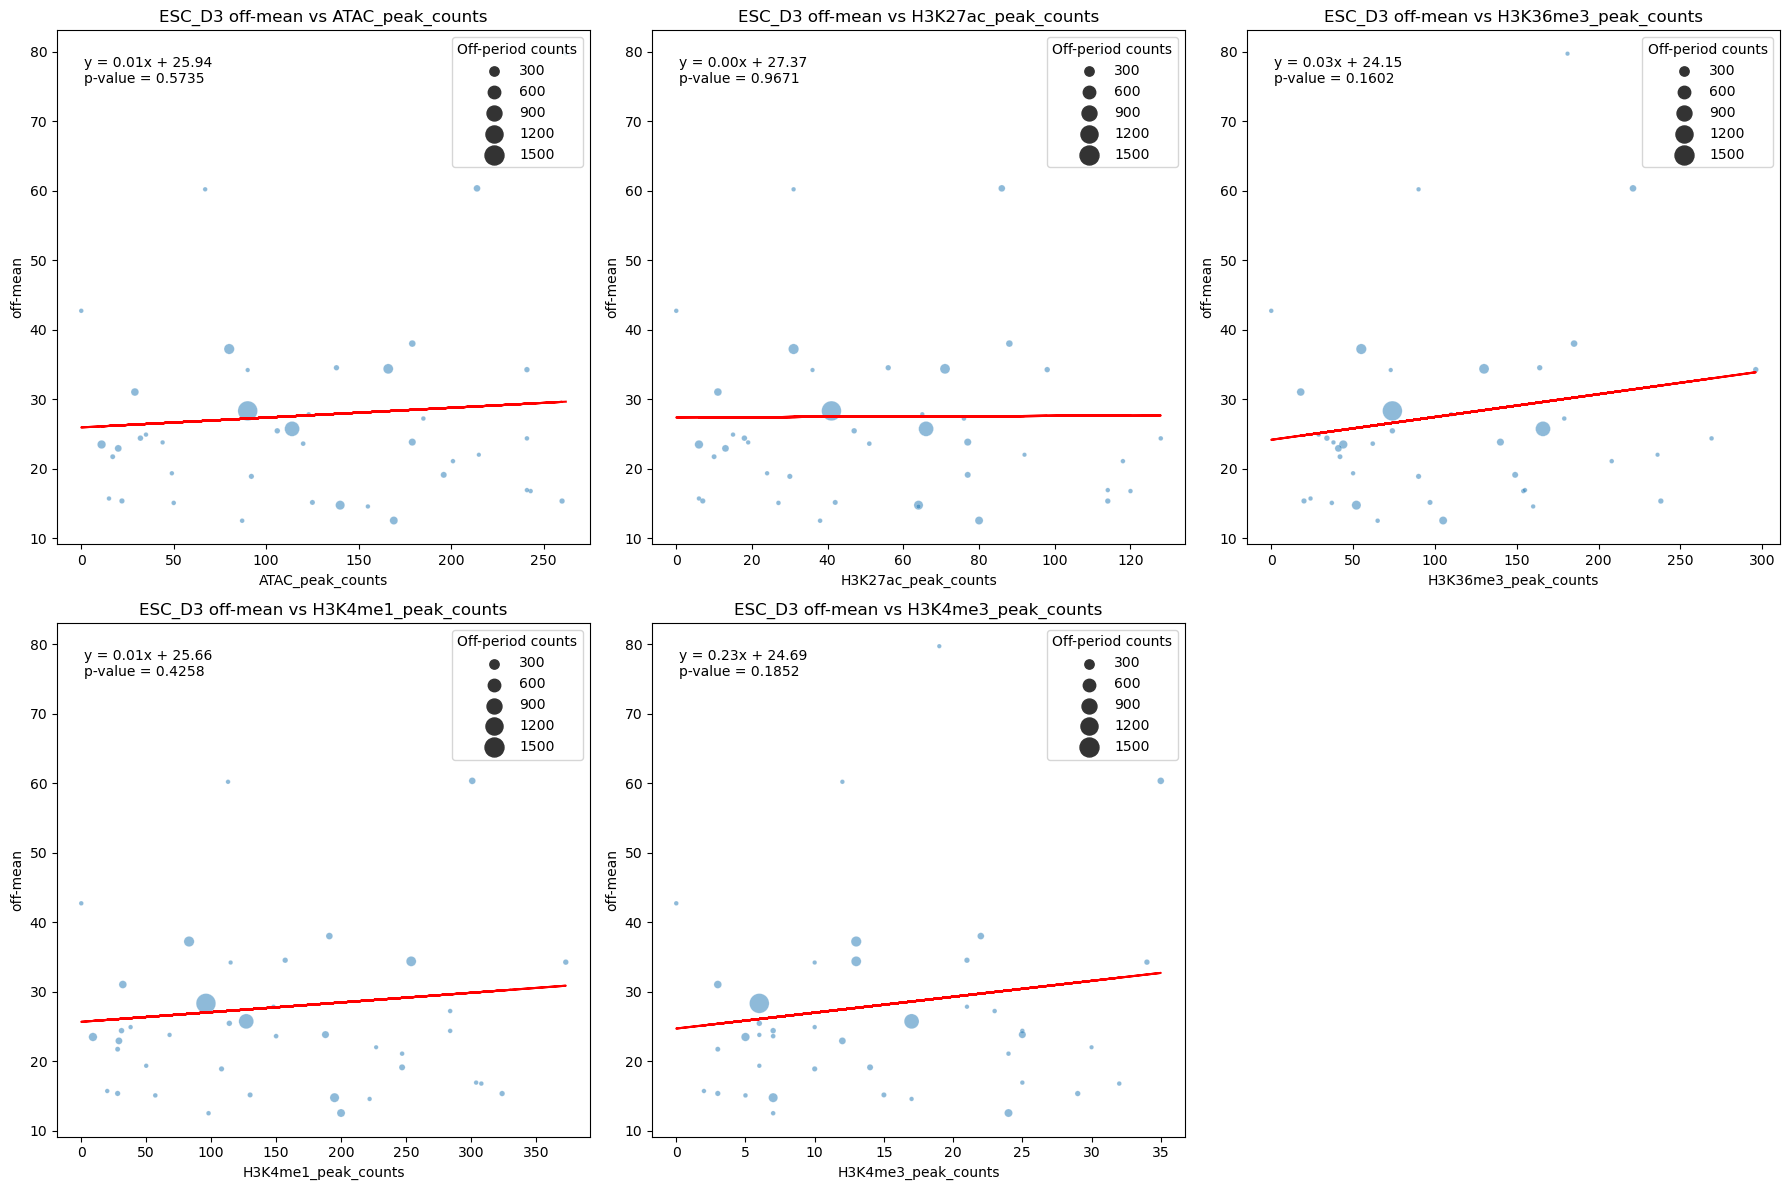

In [33]:
data = df

columns = ['ATAC_peak_counts', 'H3K27ac_peak_counts','H3K36me3_peak_counts',
           'H3K4me1_peak_counts', 'H3K4me3_peak_counts',  ]

plt.figure(figsize=(18, 12))
model_info = []
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(2, 3, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    if p < 0.05:
        color = "red"
    else:
        color = "black"
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{celltype} {y_col} vs {x_col}')

    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')
    
    print(col, f'{m:.2f}  {p:.4f}')
    model_info.append(f'{m:.2f}')
    model_info.append(f'{p:.4f}')
print(' '.join(map(str, model_info)))
plt.tight_layout()
plt.show()


ATAC_peak_coverage 0.00  0.5100
H3K27ac_peak_coverage 0.00  0.5557
H3K36me3_peak_coverage 0.00  0.1418
H3K4me1_peak_coverage 0.00  0.4504
H3K4me3_peak_coverage 0.00  0.2125
0.00 0.5100 0.00 0.5557 0.00 0.1418 0.00 0.4504 0.00 0.2125


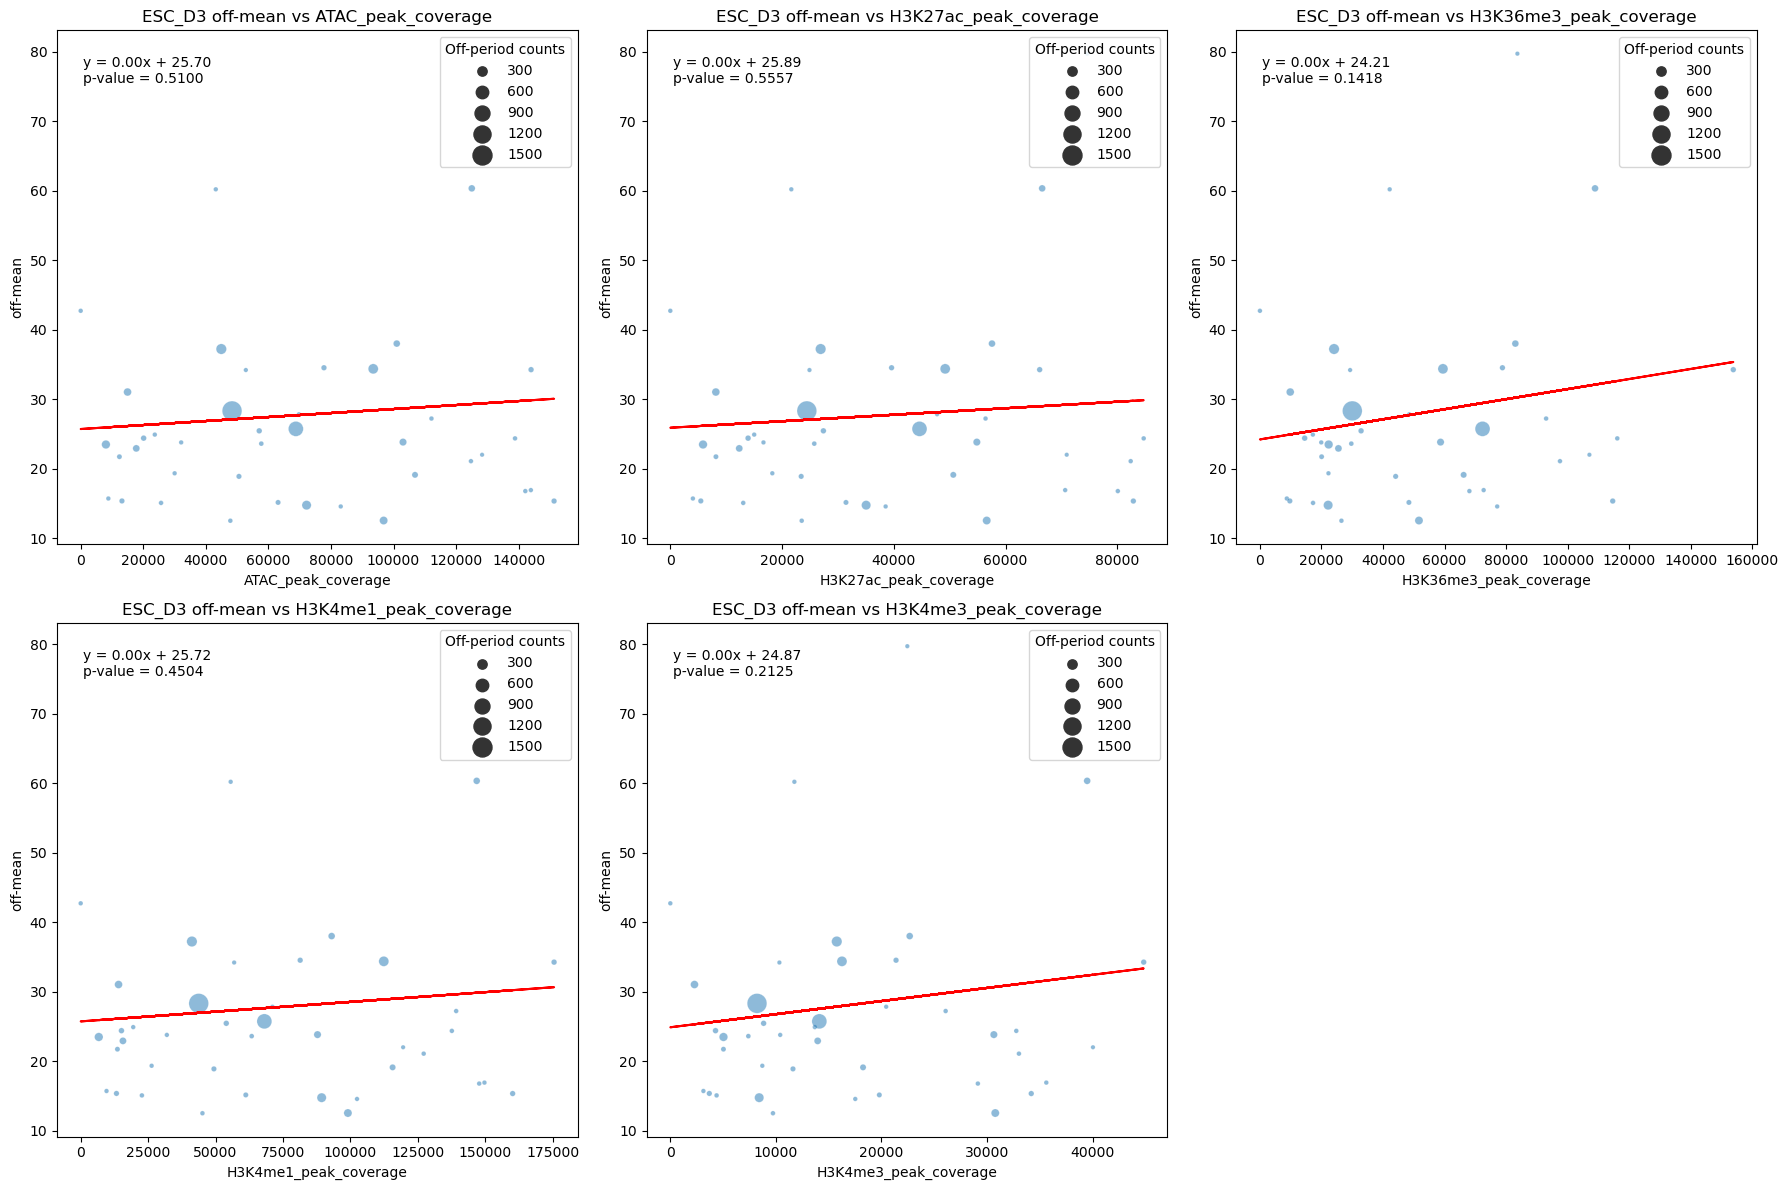

In [34]:
data = df

columns = ['ATAC_peak_coverage', 'H3K27ac_peak_coverage','H3K36me3_peak_coverage',
           'H3K4me1_peak_coverage', 'H3K4me3_peak_coverage',  ]

plt.figure(figsize=(18, 12))
model_info = []
for i, col in enumerate(columns):
    y_col = 'off-mean' #'off-median' #'off-mean' # 'K-on-rate'
    x_col = col

    ax = plt.subplot(2, 3, i + 1)
    sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, size='off-period-counts', 
                    sizes=(10, 200), alpha=0.5, marker='o')

    # Prepare data for weighted regression
    x = data[x_col]
    y = data[y_col] #.dropna()  # Drop NaN values

    weights = data['off-period-counts']  # Use off-period-counts as weights

    # Weighted regression
    X = sm.add_constant(x)
    model = sm.WLS(y, X, weights=weights).fit()

    # Plot regression line
    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    if p < 0.05:
        color = "red"
    else:
        color = "black"
    ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{celltype} {y_col} vs {x_col}')

    # Legend for size scale
    ax.legend(title='Off-period counts', loc='upper right')
    
    print(col, f'{m:.2f}  {p:.4f}')
    model_info.append(f'{m:.2f}')
    model_info.append(f'{p:.4f}')
print(' '.join(map(str, model_info)))
plt.tight_layout()
plt.show()
